This notebook will go over the typical pytorch lightning workflow.

## Define a lightning module

In [4]:
import os
from torch import optim, nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import lightning.pytorch as pl

In [16]:
# first up we have any number of nn.Modules
encoder = nn.Sequential(nn.Linear(28 * 28, 128), nn.ReLU(), nn.Linear(128, 16))
decoder = nn.Sequential(nn.Linear(16, 128), nn.ReLU(), nn.Linear(128, 28 * 28))

# now the lightning module
# a lightning module allows nn.Modules to play together in complex ways and abstracts away a lot of the boilerplate
class LitAutoEncoder(pl.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def training_step(self, batch, batch_idx):
        # training step defines the train loop
        # it is independent of forward
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=1e-3)
        return optimizer
    
# init the autoencoder
autoencoder = LitAutoEncoder(encoder, decoder)

## Define the dataset

In [17]:
# lightning supports ANY iterable for the train/val/test/predict splits
dataset = MNIST(os.getcwd(), train=True, download=True, transform=ToTensor())
train_loader = DataLoader(dataset, batch_size=32)

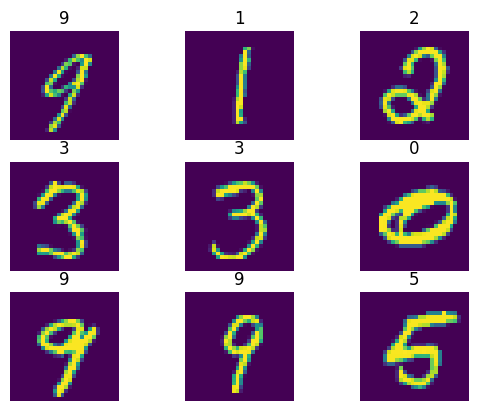

In [18]:
# lets view some images
import matplotlib.pyplot as plt
import numpy as np
# pick 9 random images and show in a 3x3 grid

fig, ax = plt.subplots(3, 3)
for i, j in enumerate(np.random.randint(0, len(dataset), 9)):
    ax[i // 3, i % 3].imshow(dataset[j][0].squeeze())
    ax[i // 3, i % 3].set_title(dataset[j][1])
    ax[i // 3, i % 3].axis("off")

## Train the model

In [22]:
# training happens through a lightning trainer - the trainer is powerful and allows for distributed training, early stopping, logging, model checkpointing and more
trainer = pl.Trainer(limit_train_batches=100, max_epochs=10)
trainer.fit(model=autoencoder, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 102 K 
1 | decoder | Sequential | 103 K 
---------------------------------------
205 K     Trainable params
0         Non-trainable params
205 K     Total params
0.823     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Use the model

In [23]:
# save the model (other ways to do this via callbacks that are better)
checkpoint = trainer.save_checkpoint("model.ckpt")

# load the model
new_model = LitAutoEncoder.load_from_checkpoint("./model.ckpt", encoder=encoder, decoder=decoder)

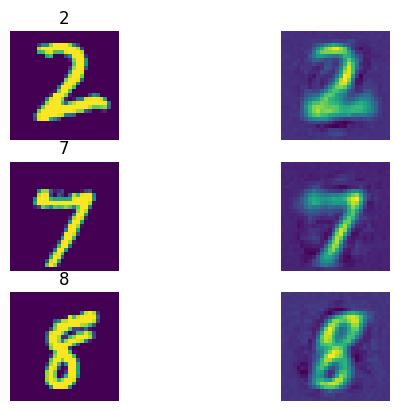

In [28]:
# lets see how it does
enc = new_model.encoder
enc.eval()
dec = new_model.decoder
dec.eval()

# pick 3 random images, show the original and the enc_dec version side by side in a 3x2 grid
fig, ax = plt.subplots(3, 2)
for i, j in enumerate(np.random.randint(0, len(dataset), 3)):
    ax[i, 0].imshow(dataset[j][0].squeeze())
    ax[i, 0].set_title(dataset[j][1])
    ax[i, 0].axis("off")
    x = dataset[j][0].view(1, -1)
    z = enc(x)
    x_hat = dec(z)
    ax[i, 1].imshow(x_hat.detach().numpy().reshape(28, 28))
    ax[i, 1].axis("off")

# not terrible for such a simple model and about 10s of training